# AML Hierarchy - Survival Analysis

In [1]:
library(tidyverse)
library(survival)
library(survminer)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggpubr


### Survival across TCGA, BEAT-AML, and GSE6891 Cohorts



In [4]:
cohortsurv <- read_csv('Data/Fig2_Cohort_Deconvolution/Survival_Hierarchy_TCGA_BEAT_GSE6891.csv')
cohortsurv %>% head()

Parsed with column specification:
cols(
  Cohort = col_character(),
  Patient = col_character(),
  os = col_double(),
  osi = col_double(),
  Cluster = col_character(),
  Age = col_double(),
  CytogeneticRisk = col_character(),
  WBC = col_double(),
  NPM1 = col_character(),
  FLT3ITD = col_character(),
  PC1 = col_double(),
  PC2 = col_double(),
  PC1_cat = col_character(),
  PC2_cat = col_character()
)


Cohort,Patient,os,osi,Cluster,Age,CytogeneticRisk,WBC,NPM1,FLT3ITD,PC1,PC2,PC1_cat,PC2_cat
GSE6891,GSM158711,5271.0,0,Intermediate,54,Intermediate,6.0,Positive,Positive,0.18057372,-0.14811242,High,Low
GSE6891,GSM158712,3273.0,1,GMP,38,Favorable,13.4,Negative,Negative,0.32455224,-0.15622360,High,Low
GSE6891,GSM158713,217.8,1,Primitive,33,Intermediate,14.9,Positive,Positive,-0.19199234,-0.07904103,Low,Low
GSE6891,GSM158714,7.8,1,Mature,35,Favorable,39.1,Negative,Negative,0.06801656,0.24270454,High,High
GSE6891,GSM158715,1684.5,1,Intermediate,37,Intermediate,108.1,Positive,Positive,0.26173300,-0.19160251,High,Low
GSE6891,GSM158716,162.6,1,GMP,50,Favorable,117.0,Negative,Negative,0.27123153,-0.16447462,High,Low


Load cell type composition info for TCGA and BEAT-AML cohorts (RNA-seq). Note that we are excluding composition data from GSE6891 in this case because deconvolution from microarray is less accurate

In [3]:
compositions <- read_csv('Data/Cohort_Hierarchy_Genomic_Annotations.csv') %>% 
  select(Patient = X1, Cohort, 'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like') %>% 
  filter(Cohort %in% c('TCGA', 'BEAT')) 
cohort_compositions <- cohortsurv %>% filter(Cohort %in% c('TCGA', 'BEAT')) %>% left_join(compositions) 
cohort_compositions %>% head()

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character(),
  Age = col_double(),
  `LSPC-Quiescent` = col_double(),
  `LSPC-Primed` = col_double(),
  `LSPC-Cycle` = col_double(),
  `GMP-like` = col_double(),
  `ProMono-like` = col_double(),
  `Mono-like` = col_double(),
  `cDC-like` = col_double(),
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  NMF1 = col_double(),
  NMF2 = col_double(),
  NMF3 = col_double(),
  `LSC-17` = col_double(),
  `LinClass-7` = col_double(),
  ASXL1_VAF = col_double(),
  ASXL2_VAF = col_double()
  # ... with 37 more columns
)
See spec(...) for full column specifications.
Joining, by = c("Cohort", "Patient")


Cohort,Patient,os,osi,Cluster,Age,CytogeneticRisk,WBC,NPM1,FLT3ITD,...,PC2,PC1_cat,PC2_cat,LSPC-Quiescent,LSPC-Primed,LSPC-Cycle,GMP-like,ProMono-like,Mono-like,cDC-like
TCGA,TCGA-AB-2803,792,1,GMP,61,Favorable,1.0,Negative,Negative,...,0.05338886,High,Low,0.08360460,0.04361398,0.000000000,0.484825070,0.214481000,0.00000000,0.173475340
TCGA,TCGA-AB-2805,577,1,Mature,77,Intermediate,92.0,Negative,Negative,...,-0.35105562,Low,Low,0.02012835,0.16499612,0.067478310,0.003462018,0.004699103,0.36630055,0.372935530
TCGA,TCGA-AB-2806,945,1,GMP,46,Favorable,29.4,Negative,Negative,...,0.10751210,High,High,0.00000000,0.21896525,0.005200822,0.660971340,0.007805404,0.04810568,0.058951420
TCGA,TCGA-AB-2807,181,1,Primitive,68,Intermediate,3.1,Negative,Negative,...,0.08849948,Low,High,0.20040579,0.24122742,0.289100800,0.010346723,0.027681597,0.00000000,0.231237740
TCGA,TCGA-AB-2808,2861,0,Intermediate,23,Intermediate,32.4,Negative,Negative,...,-0.05768136,High,Low,0.03185005,0.14509666,0.230763780,0.242078300,0.142588140,0.19865969,0.008963276
TCGA,TCGA-AB-2810,31,1,Intermediate,76,NA,61.6,Positive,Negative,...,0.13816275,High,High,0.27957603,0.00000000,0.000000000,0.476778030,0.089819340,0.03606095,0.117765605


### Survival Regression by leukemic cell composition

This is not a genuine attempt at creating a survival score but rather a way to understand which cell types may be most closely associated with survival 


In [2]:
library(glmnet)

## Train LASSO on CoxPH Function ##########################################################################
train_survival_hierarchy <- function(x_features, y_surv, lasso_approach = c('lasso', 'ridge'), cv_folds = 10, loss = c('deviance', 'C')){
  ### Train Model
  if(lasso_approach == 'lasso'){
    model <- cv.glmnet(x = x_features, y = y_surv, type.measure = loss, nfold = cv_folds, family = 'cox', alpha = 1, maxit=1000000, standardize=FALSE)
    plot(model)
  }
  if(lasso_approach == 'ridge'){
    ## Perform ridge regression to get feature-specific penalty factors
    model <- cv.glmnet(x = x_features, y = y_surv, type.measure = loss, nfold = cv_folds, family = 'cox', alpha = 0, maxit=1000000, standardize=FALSE)
    plot(model) 
  }
  return(model)
}

Loading required package: Matrix
Loaded glmnet 4.1-3
Loading required package: ggplot2
Loading required package: ggpubr


In [7]:
cohort_compositions <- cohort_compositions %>% filter(os > 0)

# Set up y - survival function
y_surv <- stratifySurv(Surv(time = cohort_compositions$os, event = cohort_compositions$osi), strata = cohort_compositions$Cohort)
# Set up X - expression matrix 
cohort_deconv <- cohort_compositions %>% select(contains('LSPC'), contains('like')) %>% data.matrix()
rownames(cohort_deconv) <- cohort_compositions$Patient
cohort_deconv[1:10, 1:5]


,LSPC-Quiescent,LSPC-Primed,LSPC-Cycle,GMP-like,ProMono-like
TCGA-AB-2803,0.08360460,0.0436139780,0.000000000,0.484825070,0.214481000
TCGA-AB-2805,0.02012835,0.1649961200,0.067478310,0.003462018,0.004699103
TCGA-AB-2806,0.00000000,0.2189652500,0.005200822,0.660971340,0.007805404
TCGA-AB-2807,0.20040579,0.2412274200,0.289100800,0.010346723,0.027681597
TCGA-AB-2808,0.03185005,0.1450966600,0.230763780,0.242078300,0.142588140
TCGA-AB-2810,0.27957603,0.0000000000,0.000000000,0.476778030,0.089819340
TCGA-AB-2811,0.17410912,0.0482458600,0.068151250,0.056535635,0.000000000
TCGA-AB-2812,0.07212189,0.2841742600,0.179289670,0.168371400,0.197146730
TCGA-AB-2813,0.05253596,0.0003563154,0.153585800,0.064637790,0.025068546
TCGA-AB-2814,0.51471750,0.3015328300,0.116384424,0.001327308,0.056021556


To understand which celltypes are most useful, perform lasso regression on cox proportional hazards ratio with leave-one-out cross validation and then look at the weights for each celltype



Call:  cv.glmnet(x = x_features, y = y_surv, type.measure = loss, nfolds = cv_folds,      family = "cox", alpha = 1, maxit = 1e+06, standardize = FALSE) 

Measure: Partial Likelihood Deviance 

     Lambda Index Measure      SE Nonzero
min 0.00401    25   8.714 0.09866       3
1se 0.03735     1   8.786 0.09684       0

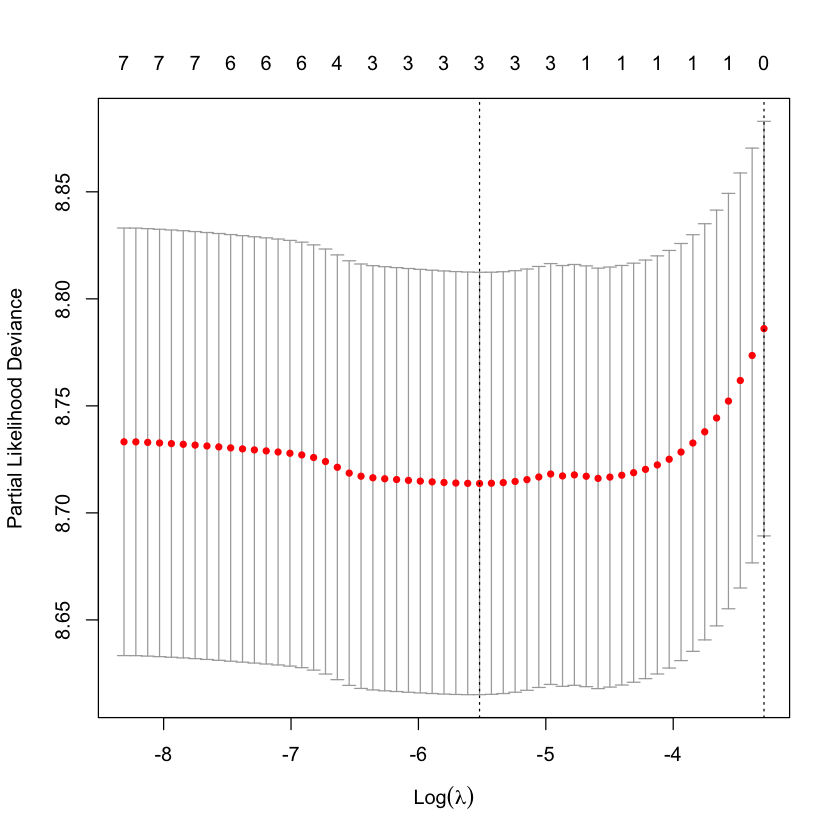

In [8]:
model <- train_survival_hierarchy(cohort_deconv, y_surv, lasso_approach = 'lasso', cv_folds = dim(cohort_deconv)[1], loss='deviance')
model


In [9]:
## Evaluate Model 
pred_y <- predict(model, cohort_deconv, s = 'lambda.min') %>% 
  data.frame() %>% rownames_to_column('Patient') %>% dplyr::rename(Score = X1) %>% 
  left_join(cohortsurv) %>% 
  #left_join(lsc_scores %>% select(Patient, LSC17_logTPM)) %>% 
  ungroup() %>%
  # Category based on Median Split
  mutate(category = if_else(Score > median(predict(model, cohort_deconv, s = 'lambda.min')), 'High', 'Low') %>% factor(levels = c('Low', 'High')))
pred_y$y_surv <- y_surv

summary(coxph(y_surv ~ Score + strata(Cohort), data = pred_y))


Joining, by = "Patient"


Call:
coxph(formula = y_surv ~ Score + strata(Cohort), data = pred_y)

  n= 399, number of events= 214 

        coef exp(coef) se(coef)     z Pr(>|z|)    
Score 1.2099    3.3532   0.2286 5.294  1.2e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

      exp(coef) exp(-coef) lower .95 upper .95
Score     3.353     0.2982     2.142     5.248

Concordance= 0.595  (se = 0.022 )
Likelihood ratio test= 32.48  on 1 df,   p=1e-08
Wald test            = 28.02  on 1 df,   p=1e-07
Score (logrank) test = 28.94  on 1 df,   p=7e-08


In [10]:
coef(model, s='lambda.min')



7 x 1 sparse Matrix of class "dgCMatrix"
                        1
LSPC-Quiescent  0.3381840
LSPC-Primed     .        
LSPC-Cycle      0.7186969
GMP-like       -1.5366549
ProMono-like    .        
Mono-like       .        
cDC-like        .        

In this model, Quiescent LSPC and Cycling LSPC are prognostically adverse while GMP-like abundance is prognostically favorable. 
This LSPC vs GMP weighting strongly resembles PC1 (Primitive vs GMP), does this score correlate with PC1?


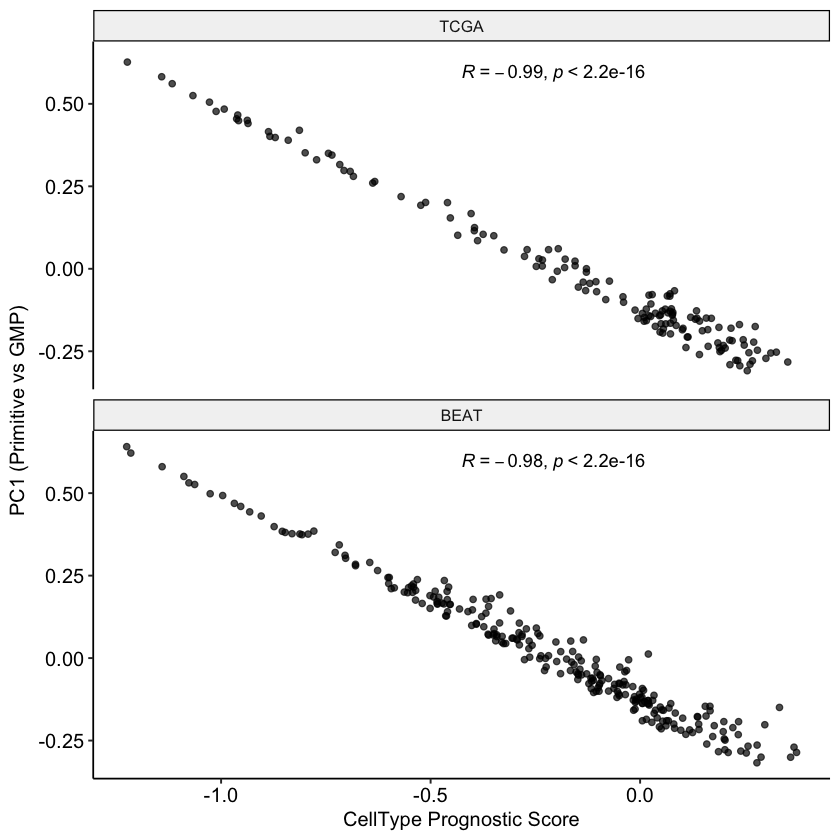

In [11]:
pred_y %>% 
  mutate(Cohort = factor(Cohort, levels = c("TCGA", "BEAT"))) %>% 
  ggplot(aes(x = Score, y = PC1)) + 
  geom_point(alpha=0.7) + 
  stat_cor(label.x.npc = 0.5) + 
  theme_pubr() + 
  facet_wrap(.~Cohort, ncol=1) + 
  xlab('CellType Prognostic Score') + ylab('PC1 (Primitive vs GMP)')


It turns out that training a de novo survival score from leukemic cell types near-perfectly recapitulates the first principal component from clustering patients (Primitive vs GMP). 
Thus that axis already captures variation underlying survival and there is no need to train a score de novo.


### Analysis by Hierarchy Cluster


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

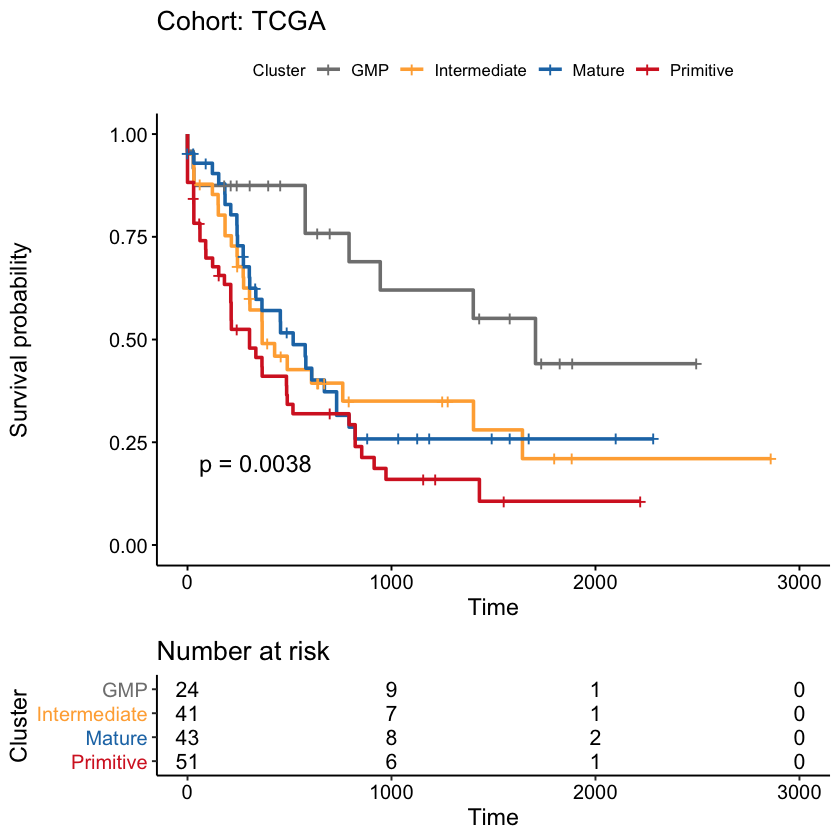

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

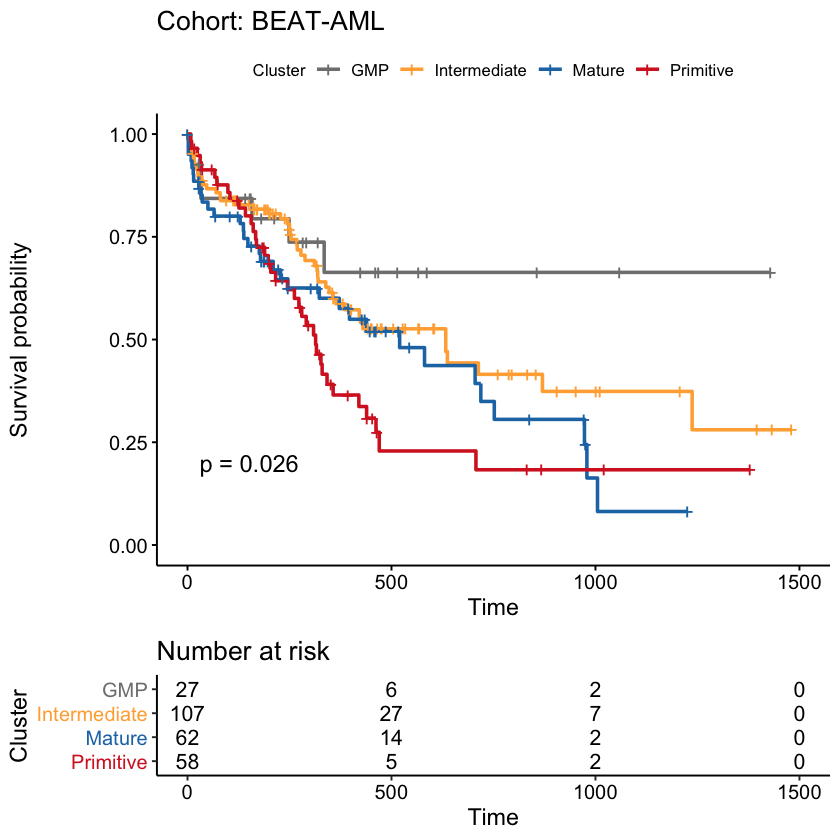

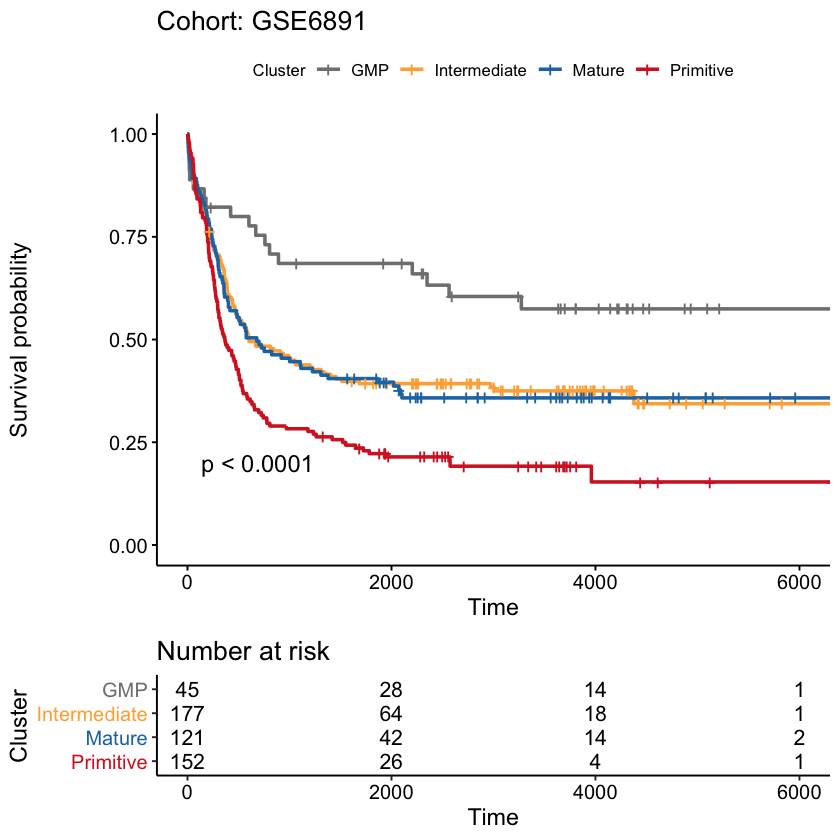

In [38]:
survfit(Surv(os, osi) ~ Cluster, data = cohortsurv %>% filter(Cohort == 'TCGA')) %>% 
  ggsurvplot(pval = T, risk.table = T, legend.title='Cluster', 
             legend.labs = c('GMP', 'Intermediate', 'Mature', 'Primitive'), palette = c('#808080', '#FFAD41', '#1f77b4', '#d62728'), title = 'Cohort: TCGA')

survfit(Surv(os, osi) ~ Cluster, data = cohortsurv %>% filter(Cohort == 'BEAT')) %>% 
  ggsurvplot(pval = T, risk.table = T, legend.title='Cluster', 
             legend.labs = c('GMP', 'Intermediate', 'Mature', 'Primitive'), palette = c('#808080', '#FFAD41', '#1f77b4', '#d62728'), title = 'Cohort: BEAT-AML')

survfit(Surv(os, osi) ~ Cluster, data = cohortsurv %>% filter(Cohort == 'GSE6891')) %>% 
  ggsurvplot(pval = T, risk.table = T, legend.title='Cluster', 
             legend.labs = c('GMP', 'Intermediate', 'Mature', 'Primitive'), palette = c('#808080', '#FFAD41', '#1f77b4', '#d62728'), title = 'Cohort: GSE6891')


Trends are similar across clusters but variable. Let's perform meta-analysis across the cohorts to get pooled hazard ratios 

**One vs All Comparisons**


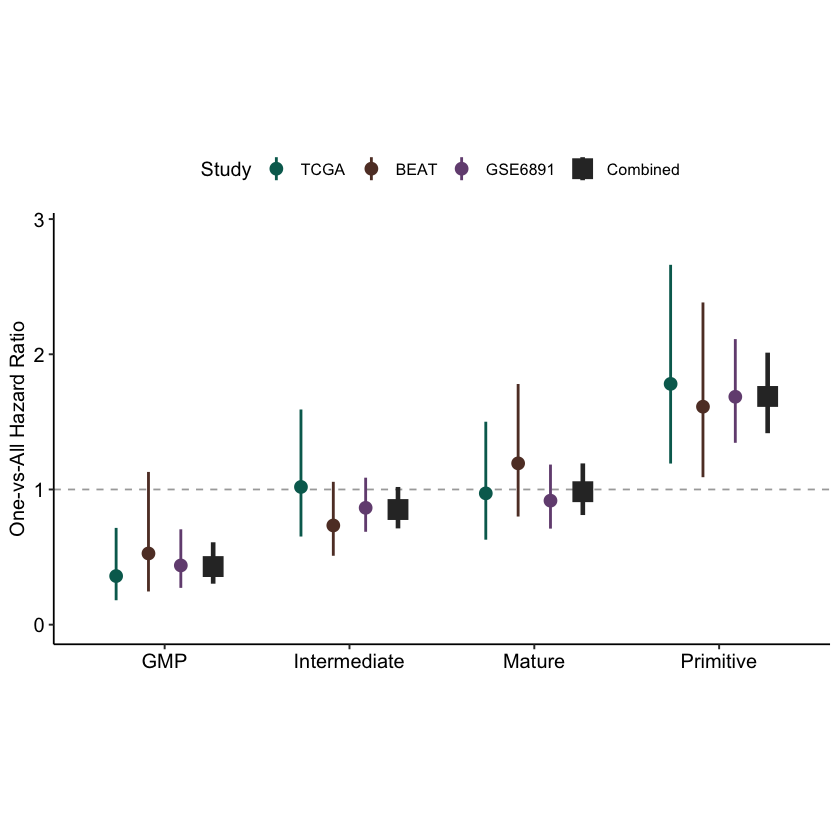

In [39]:
query_clust = c('Primitive', 'Mature', 'Intermediate', 'GMP')

df <- data.frame()

for(i in c(1:length(query_clust))){
  query <- query_clust[i]

  # Run for each study
  for(study in c('TCGA', 'BEAT', 'GSE6891')){
    temp_df = cohortsurv %>% 
      mutate(onevsall = ifelse(Cluster == query, 1, 0)) %>% 
      filter(Cohort == study)
    temp_model <- coxph(Surv(os, osi) ~ onevsall, temp_df)
    HR = summary(temp_model)$conf.int[1]
    lwr = summary(temp_model)$conf.int[3]
    upr = summary(temp_model)$conf.int[4]
    pval = summary(temp_model)$coefficients[,5]
    n = summary(temp_model)$n

    df <- rbind(df, data.frame('Cluster' = query, 'Study' = study, 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 
                             'pval' = pval, 'n' = n))
  }

  # Repeat for combined Cohorts
  temp_df = cohortsurv %>% 
      mutate(onevsall = ifelse(Cluster == query, 1, 0)) 
  temp_model <- coxph(Surv(os, osi) ~ onevsall + strata(Cohort), temp_df)
  HR = summary(temp_model)$conf.int[1]
  lwr = summary(temp_model)$conf.int[3]
  upr = summary(temp_model)$conf.int[4]
  pval = summary(temp_model)$coefficients[,5]
  n = summary(temp_model)$n

  df <- rbind(df, data.frame('Cluster' = query, 'Study' = 'Combined', 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 
                             'pval' = pval, 'n' = n))
}


df %>% 
  mutate(Cluster = factor(Cluster, levels = c('GMP', 'Intermediate', 'Mature', 'Primitive'))) %>% 
  mutate(Study = factor(Study, levels = c('TCGA', 'BEAT', 'GSE6891', 'Combined'))) %>% 
  ggplot(aes(x = Cluster, y = HR, ymax = upr, ymin = lwr, group = Study)) + 
  geom_hline(yintercept = 1, lty = 2, size = 0.5, alpha = 1, color = 'darkgrey') + 
  geom_pointrange(aes(shape=Study, color=Study, size=Study), position=position_dodge(width=c(0.7))) + 
  scale_shape_manual(values=c(16, 16, 16, 15)) +
  scale_color_manual(values=c('#006A5D', '#603C30', '#744F80', '#303030')) +
  scale_size_manual(values=c(0.8, 0.8, 0.8, 1.3)) +
  theme_pubr() + #theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
  xlab('') + ylab('One-vs-All Hazard Ratio') + ylim(c(0, 2.9)) +
  theme(aspect.ratio=1/1.8)


**Pair-wise Comparisons**



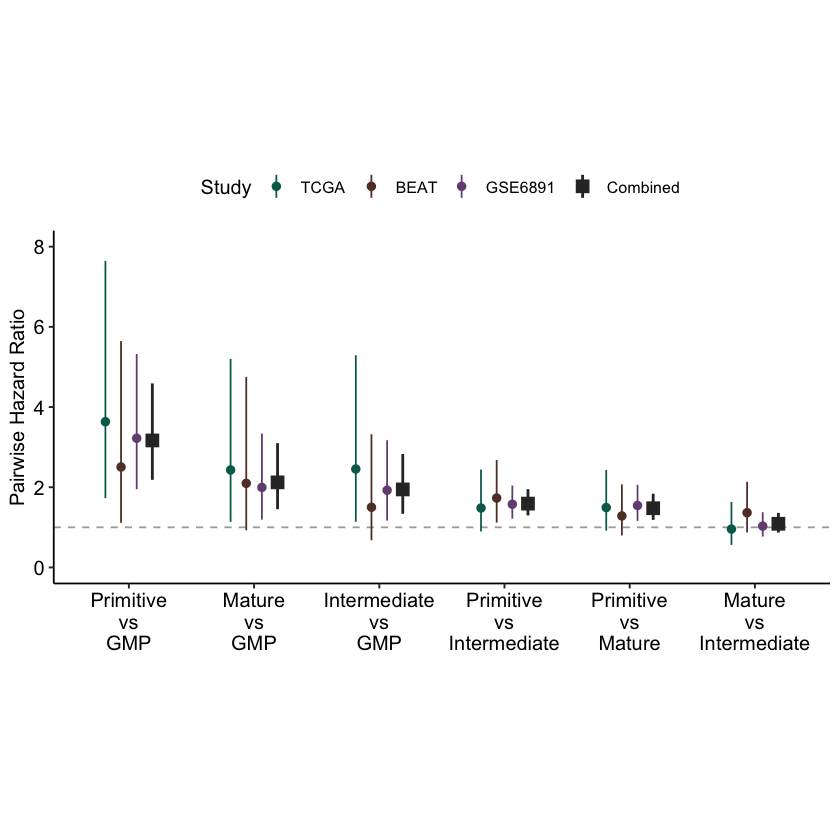

In [12]:
comparisons <- data.frame(
  ref = c('GMP', 'GMP', 'GMP', 'Intermediate', 'Mature', 'Intermediate'), 
  query = c('Primitive', 'Mature', 'Intermediate', 'Primitive', 'Primitive', 'Mature')
)


df <- data.frame()

for(i in c(1:dim(comparisons)[1])){
  ref <- comparisons$ref[i] %>% as.character()
  query <- comparisons$query[i] %>% as.character()
  
  # Run for each study
  for(study in c('TCGA', 'BEAT', 'GSE6891')){
    temp_df = cohortsurv %>% 
      filter(Cluster %in% c(query, ref)) %>% mutate(Cluster = factor(Cluster, levels = c(ref, query))) %>% 
      filter(Cohort == study)
    temp_model <- coxph(Surv(os, osi) ~ Cluster, temp_df)
    HR = summary(temp_model)$conf.int[1]
    lwr = summary(temp_model)$conf.int[3]
    upr = summary(temp_model)$conf.int[4]
    pval = summary(temp_model)$coefficients[,5]
    n = summary(temp_model)$n
    
    df <- rbind(df, data.frame('Comparison' = factor(paste0(query, '\nvs\n', ref)), 'Study' = study, 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))
  }

  # Repeat for combined Cohorts
  temp_df = cohortsurv %>% 
    filter(Cluster %in% c(query, ref)) %>% mutate(Cluster = factor(Cluster, levels = c(ref, query)))
  temp_model <- coxph(Surv(os, osi) ~ Cluster + strata(Cohort), temp_df)
  HR = summary(temp_model)$conf.int[1]
  lwr = summary(temp_model)$conf.int[3]
  upr = summary(temp_model)$conf.int[4]
  pval = summary(temp_model)$coefficients[,5]
  n = summary(temp_model)$n
  
  df <- rbind(df, data.frame('Comparison' = factor(paste0(query, '\nvs\n', ref)), 'Study' = 'Combined', 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))
}


df %>% 
  mutate(Study = factor(Study, levels = c('TCGA', 'BEAT', 'GSE6891', 'Combined'))) %>% 
  ggplot(aes(x = Comparison, y = HR, ymax = upr, ymin = lwr, group = Study)) + 
  geom_hline(yintercept = 1, lty = 2, size = 0.5, alpha = 1, color = 'darkgrey') + 
  geom_pointrange(aes(shape=Study, color=Study, size=Study), position=position_dodge(width=c(0.5))) + 
  scale_shape_manual(values=c(16, 16, 16, 15)) +
  scale_color_manual(values=c('#006A5D', '#603C30', '#744F80', '#303030')) +
  scale_size_manual(values=c(0.5, 0.5, 0.5, 0.8)) +
  theme_pubr() + #theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
  xlab('') + ylab('Pairwise Hazard Ratio') + ylim(c(0, 8)) +
  theme(aspect.ratio=1/2.2)

In [ ]:
df %>% 
  mutate(Study = factor(Study, levels = c('TCGA', 'BEAT', 'GSE6891', 'Combined'))) %>% 
  ggplot(aes(x = Comparison, y = HR, ymax = upr, ymin = lwr, group = Study)) + 
  geom_hline(yintercept = 1, lty = 2, size = 0.5, alpha = 1, color = 'darkgrey') + 
  geom_pointrange(aes(shape=Study, color=Study, size=Study), position=position_dodge(width=c(0.5))) + 
  scale_shape_manual(values=c(16, 16, 16, 15)) +
  scale_color_manual(values=c('#006A5D', '#603C30', '#744F80', '#303030')) +
  scale_size_manual(values=c(0.5, 0.5, 0.5, 0.8)) +
  theme_pubr() + #theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) + 
  xlab('') + ylab('Pairwise Hazard Ratio') + ylim(c(0, 8)) +
  theme(aspect.ratio=1/2.2)

Multivariate analysis incorporating cytogenetic risk, Age, WBC, NPM1 and FLT3-ITD status



In [25]:
coxph(Surv(os, osi) ~ Cluster + CytogeneticRisk + Age + WBC + NPM1 + FLT3ITD + strata(Cohort), 
      data = cohortsurv %>% mutate(Cluster = factor(Cluster, levels = c('GMP', 'Intermediate', 'Mature', 'Primitive')))) 


Call:
coxph(formula = Surv(os, osi) ~ Cluster + CytogeneticRisk + Age + 
    WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv %>% 
    mutate(Cluster = factor(Cluster, levels = c("GMP", "Intermediate", 
        "Mature", "Primitive"))))

                                  coef  exp(coef)   se(coef)      z        p
ClusterIntermediate          0.1327474  1.1419616  0.2319069  0.572  0.56704
ClusterMature                0.1597140  1.1731754  0.2453646  0.651  0.51509
ClusterPrimitive             0.3884714  1.4747248  0.2427671  1.600  0.10956
CytogeneticRiskFavorable    -1.1461195  0.3178679  0.1970657 -5.816 6.03e-09
CytogeneticRiskIntermediate -0.5425947  0.5812382  0.1213503 -4.471 7.77e-06
Age                          0.0244691  1.0247709  0.0033681  7.265 3.73e-13
WBC                          0.0016752  1.0016766  0.0006616  2.532  0.01135
NPM1Positive                -0.3505389  0.7043084  0.1147793 -3.054  0.00226
FLT3ITDPositive              0.5186641  1.6797822  0.1154397 

Perform a nested log ratio test to evaluate model improvement after including Cluster information



In [26]:
nested_lrt <- anova(
  coxph(Surv(os, osi) ~ CytogeneticRisk + Age + WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv), 
  coxph(Surv(os, osi) ~ Cluster + CytogeneticRisk +  Age + WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv))# %>% mutate(PC1_cat = factor(PC1_cat, levels = c('Low', 'High')))))

nested_lrt


loglik,Chisq,Df,P(>|Chi|)
-2523.879,NA,NA,NA
-2520.606,6.545618,3,0.0878807


In this case cluster information is only marginally significant in its prognostic value after adjusting for common prognostic variables. 
Perhaps not all variation between patients is prognostically valuable (e.g. PC2, Primitive vs Mature) and only certain aspects of variation (e.g. PC1, Primitive vs GMP) are important. 

Let's repeat the survival analysis with a focus on principal components rather than the four clusters. 



### Patient Survival by Principal Components

As expected, PC1 (Primitive vs GMP) is prognostic in all three cohorts


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

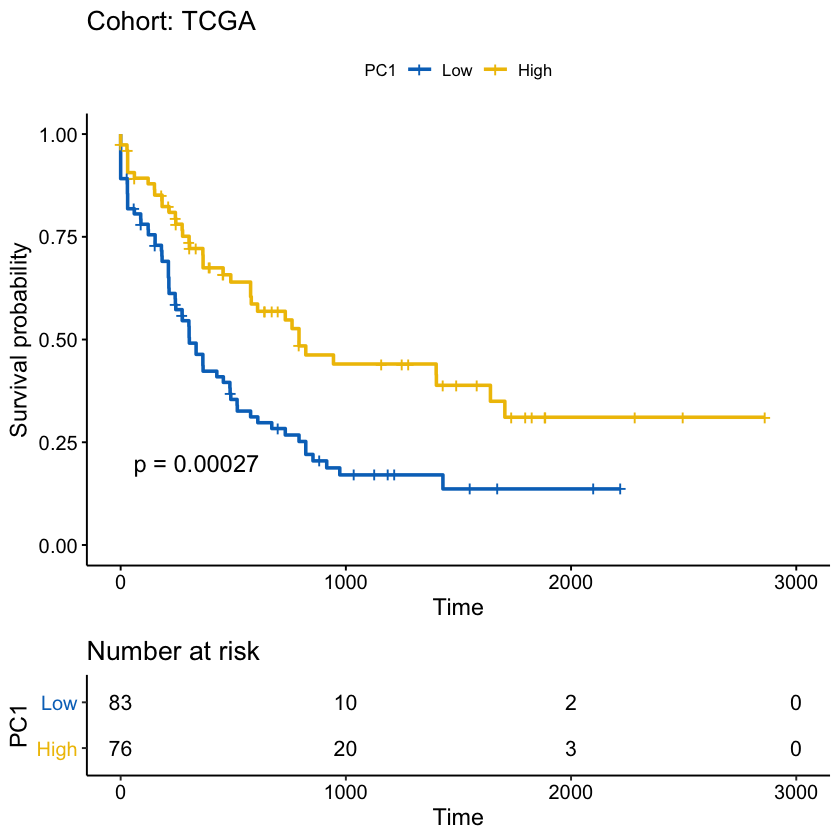

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

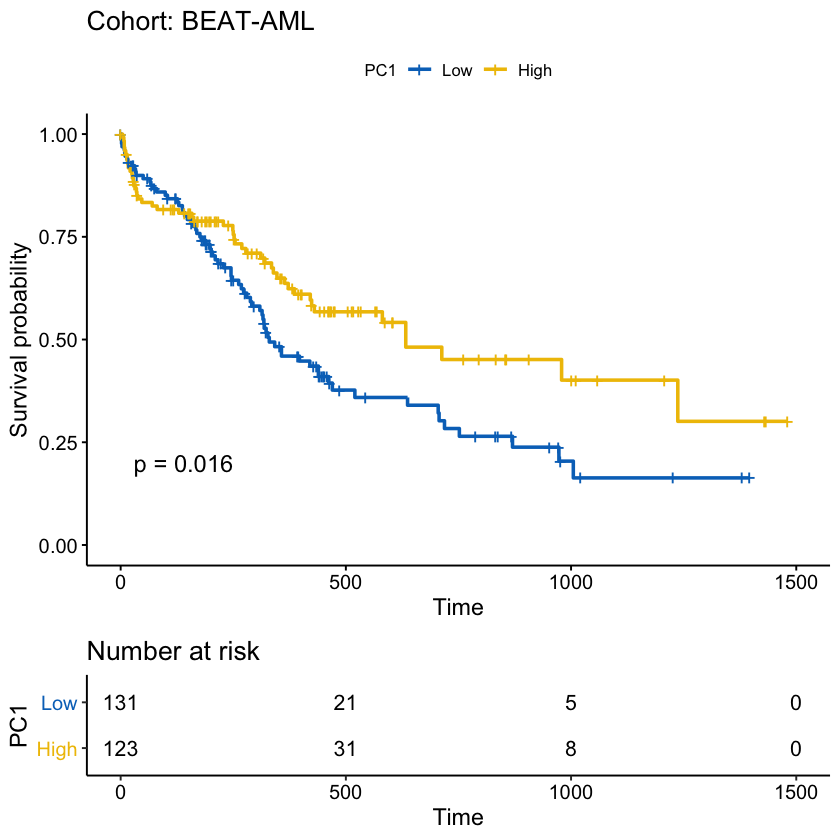

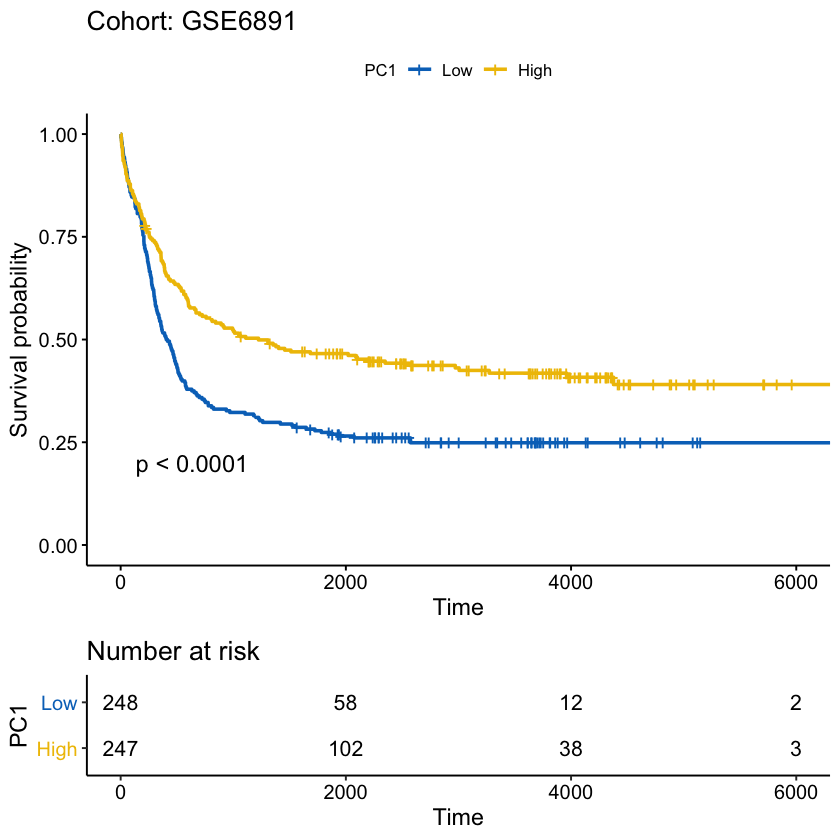

In [35]:
cohortsurv <- cohortsurv %>% mutate(PC1_cat = PC1_cat %>% factor(levels=c('Low', 'High')))
survfit(Surv(os, osi) ~ PC1_cat, data = cohortsurv %>% filter(Cohort == 'TCGA')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC1', legend.labs = c('Low', 'High'), title = 'Cohort: TCGA')
survfit(Surv(os, osi) ~ PC1_cat, data = cohortsurv %>% filter(Cohort == 'BEAT')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC1', legend.labs = c('Low', 'High'), title = 'Cohort: BEAT-AML')
survfit(Surv(os, osi) ~ PC1_cat, data = cohortsurv %>% filter(Cohort == 'GSE6891')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC1', legend.labs = c('Low', 'High'), title = 'Cohort: GSE6891')


In contrast, PC2 (Primitive vs Mature) is not prognostic in any of the three cohorts



Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

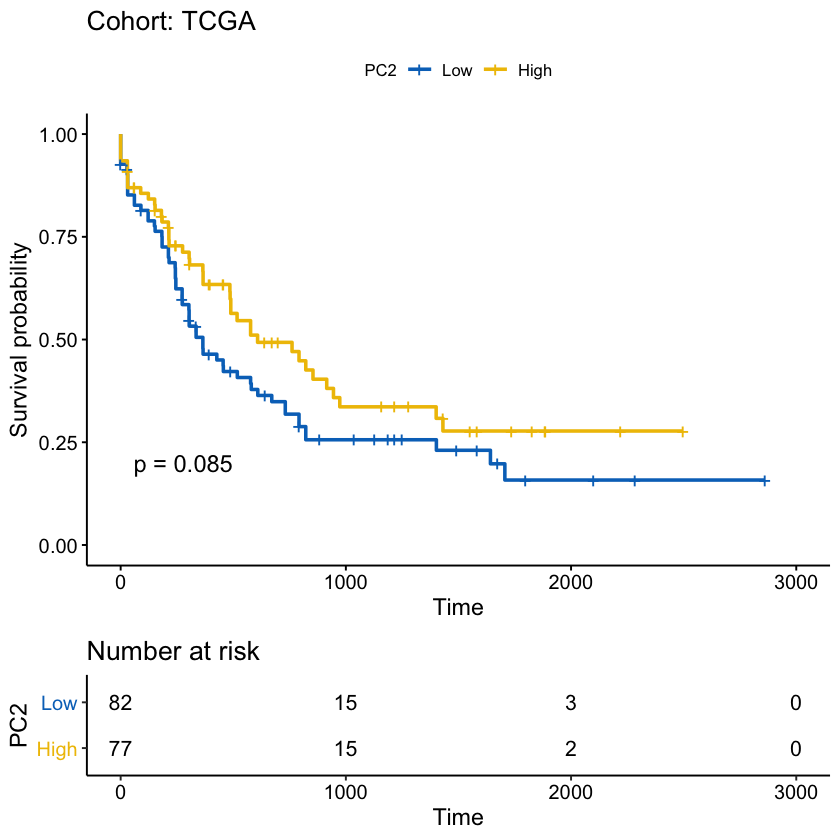

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

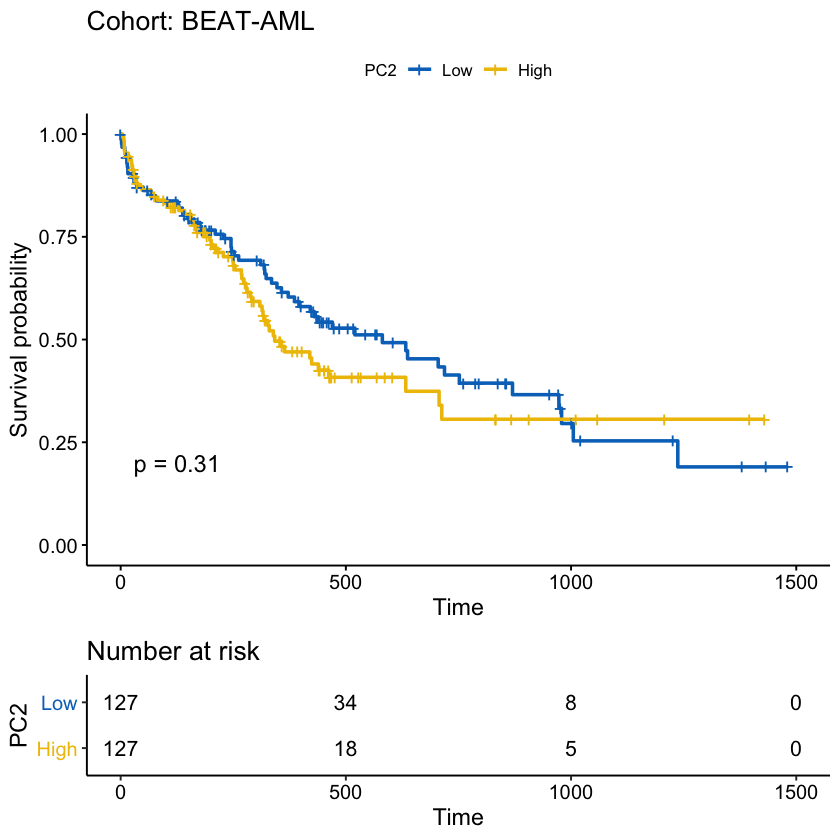

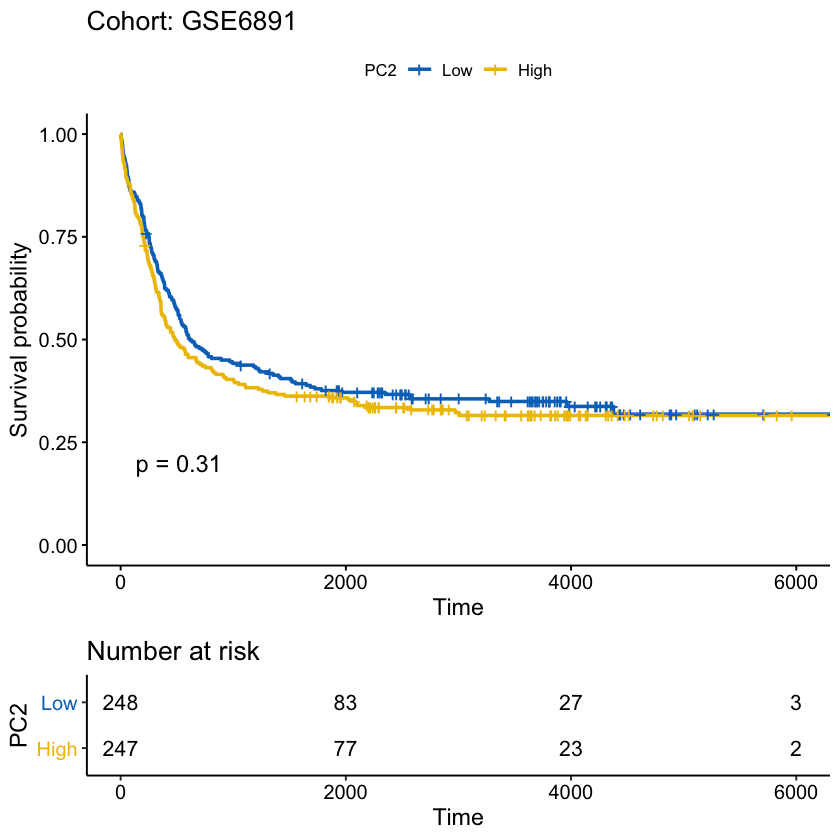

In [34]:
cohortsurv <- cohortsurv %>% mutate(PC2_cat = PC2_cat %>% factor(levels=c('Low', 'High')))
survfit(Surv(os, osi) ~ PC2_cat, data = cohortsurv %>% filter(Cohort == 'TCGA')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC2', legend.labs = c('Low', 'High'), title = 'Cohort: TCGA')
survfit(Surv(os, osi) ~ PC2_cat, data = cohortsurv %>% filter(Cohort == 'BEAT')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC2', legend.labs = c('Low', 'High'), title = 'Cohort: BEAT-AML')
survfit(Surv(os, osi) ~ PC2_cat, data = cohortsurv %>% filter(Cohort == 'GSE6891')) %>% ggsurvplot(pval = T, risk.table = T, palette = 'jco', 
                                                                                              legend.title='PC2', legend.labs = c('Low', 'High'), title = 'Cohort: GSE6891')


**Lets visualize the combined hazard ratios across all three cohorts**



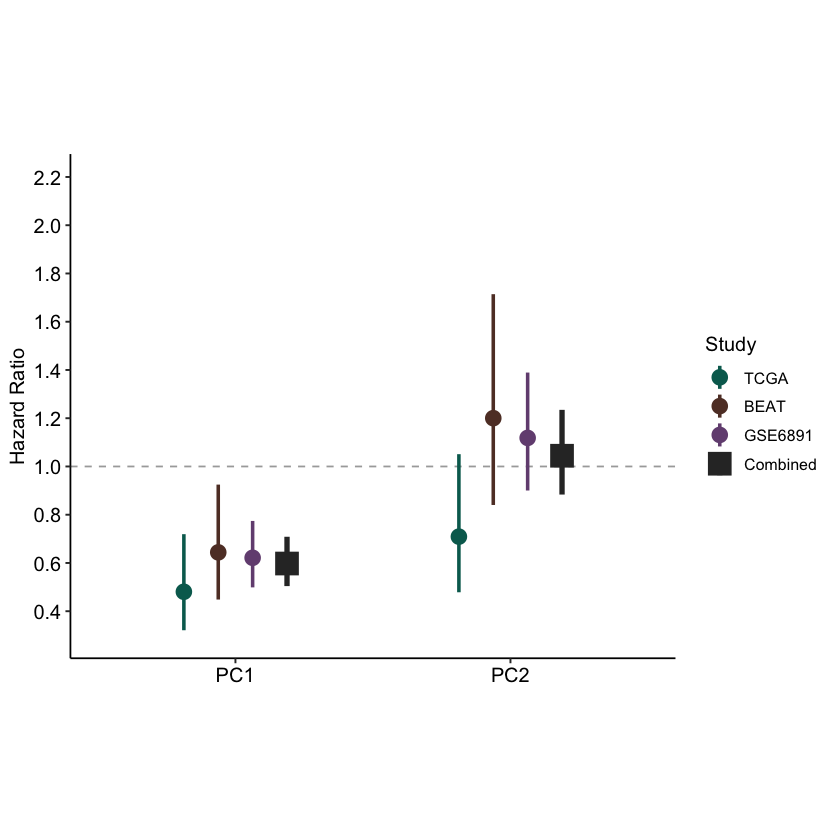

In [29]:
df <- data.frame()

## PC1
# Run for each study
for(study in c('TCGA', 'BEAT', 'GSE6891')){
  temp_df = cohortsurv %>% 
    #mutate(Cluster = factor(Cluster, levels = c(ref, query))) %>% 
    filter(Cohort == study)
  temp_model <- coxph(Surv(os, osi) ~ PC1_cat, temp_df)
  HR = summary(temp_model)$conf.int[1]
  lwr = summary(temp_model)$conf.int[3]
  upr = summary(temp_model)$conf.int[4]
  pval = summary(temp_model)$coefficients[,5]
  n = summary(temp_model)$n
  df <- rbind(df, data.frame('PC' = factor('PC1'), 'Study' = study, 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))
}

# Repeat for combined Cohorts
temp_df = cohortsurv #%>% 
  #filter(Cluster %in% c(query, ref)) %>% mutate(Cluster = factor(Cluster, levels = c(ref, query)))
temp_model <- coxph(Surv(os, osi) ~ PC1_cat + strata(Cohort), temp_df)
HR = summary(temp_model)$conf.int[1]
lwr = summary(temp_model)$conf.int[3]
upr = summary(temp_model)$conf.int[4]
pval = summary(temp_model)$coefficients[,5]
n = summary(temp_model)$n
df <- rbind(df, data.frame('PC' = factor('PC1'), 'Study' = 'Combined', 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))


## PC2
# Run for each study
for(study in c('TCGA', 'BEAT', 'GSE6891')){
  temp_df = cohortsurv %>% 
    #mutate(Cluster = factor(Cluster, levels = c(ref, query))) %>% 
    filter(Cohort == study)
  temp_model <- coxph(Surv(os, osi) ~ PC2_cat, temp_df)
  HR = summary(temp_model)$conf.int[1]
  lwr = summary(temp_model)$conf.int[3]
  upr = summary(temp_model)$conf.int[4]
  pval = summary(temp_model)$coefficients[,5]
  n = summary(temp_model)$n
  df <- rbind(df, data.frame('PC' = factor('PC2'), 'Study' = study, 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))
}

# Repeat for combined Cohorts
temp_df = cohortsurv #%>% 
  #filter(Cluster %in% c(query, ref)) %>% mutate(Cluster = factor(Cluster, levels = c(ref, query)))
temp_model <- coxph(Surv(os, osi) ~ PC2_cat + strata(Cohort), temp_df)
HR = summary(temp_model)$conf.int[1]
lwr = summary(temp_model)$conf.int[3]
upr = summary(temp_model)$conf.int[4]
pval = summary(temp_model)$coefficients[,5]
n = summary(temp_model)$n
df <- rbind(df, data.frame('PC' = factor('PC2'), 'Study' = 'Combined', 'HR' = HR, 'lwr' = lwr, 'upr' = upr, 'p' = pval, 'n' = n))


df %>% 
  mutate(Study = factor(Study, levels = c('TCGA', 'BEAT', 'GSE6891', 'Combined'))) %>% 
  ggplot(aes(x = PC, y = HR, ymax = upr, ymin = lwr, group = Study)) + 
  geom_hline(yintercept = 1, lty = 2, size = 0.5, alpha = 1, color = 'darkgrey') + 
  geom_pointrange(aes(shape=Study, color=Study, size=Study), position=position_dodge(width=c(0.5))) + 
  scale_shape_manual(values=c(16, 16, 16, 15)) +
  scale_color_manual(values=c('#006A5D', '#603C30', '#744F80', '#303030')) +
  scale_size_manual(values=c(1, 1, 1, 1.5)) +
  theme_pubr(legend = 'right') + scale_y_continuous(breaks = scales::pretty_breaks(n=8), limits = c(0.3,2.2)) + theme(axis.title.x= element_blank()) + 
  ylab('Hazard Ratio') + #ylim(c(0, 2.5)) +
  theme(aspect.ratio=1/1.2)


Does this hold up in multivariate analysis considering cytogenetic risk, age, WBC, and NPM1/FLT3-ITD status?



In [30]:
coxph(Surv(os, osi) ~ PC1_cat + CytogeneticRisk + Age + WBC + NPM1 + FLT3ITD + strata(Cohort), 
      data = cohortsurv %>% mutate(PC1_cat = factor(PC1_cat, levels = c('Low', 'High')))) 


Call:
coxph(formula = Surv(os, osi) ~ PC1_cat + CytogeneticRisk + Age + 
    WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv %>% 
    mutate(PC1_cat = factor(PC1_cat, levels = c("Low", "High"))))

                                  coef  exp(coef)   se(coef)      z        p
PC1_catHigh                 -0.2697380  0.7635795  0.1005816 -2.682 0.007323
CytogeneticRiskFavorable    -1.1469869  0.3175923  0.1800645 -6.370 1.89e-10
CytogeneticRiskIntermediate -0.5596967  0.5713823  0.1208515 -4.631 3.63e-06
Age                          0.0248362  1.0251472  0.0033870  7.333 2.25e-13
WBC                          0.0016967  1.0016981  0.0006476  2.620 0.008796
NPM1Positive                -0.3760717  0.6865531  0.1136478 -3.309 0.000936
FLT3ITDPositive              0.5458225  1.7260275  0.1121871  4.865 1.14e-06

Likelihood ratio test=179.4  on 7 df, p=< 2.2e-16
n= 821, number of events= 497 
   (128 observations deleted due to missingness)

Perform a nested log ratio test to evaluate model improvement after including PC1 (Primitive vs GMP)



In [31]:
nested_lrt <- anova(
  coxph(Surv(os, osi) ~ CytogeneticRisk + Age + WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv), 
  coxph(Surv(os, osi) ~ PC1_cat + CytogeneticRisk +  Age + WBC + NPM1 + FLT3ITD + strata(Cohort), data = cohortsurv %>% mutate(PC1_cat = factor(PC1_cat, levels = c('Low', 'High')))))

nested_lrt


loglik,Chisq,Df,P(>|Chi|)
-2523.879,NA,NA,NA
-2520.199,7.359448,1,0.006671127


In this case PC1 remains highly prognostic after adjusting for Age, WBC, Cytogenetic Risk, NPM1, and FLT3-ITD as covariates, suggesting that biological differences between primitive HSCs and more-committed GMPs may contribute to AML outcomes.  
This is not surprising as existing prognostic gene expression scores such as LSC17 actually capture variation along this Primitive vs GMP axis. 
